# This version learns a covariance matrix where there is a uniform (i.e. unconstrained) distribution over the non-diagonal entries, but with fixed diagonal entries of 1.0.

If you use a diagonal gaussian for the encoder, it fairly quickly converges to an identity matrix.

If the inference network has multivariate-normal (as opposed to diagonal normal) encoders / proposals, then something happens. Doesn't look amazing.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import sys
sys.path.insert(0,'../')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

%matplotlib inline

probtorch: 0.0+233ef39 torch: 0.3.1 cuda: False


In [2]:
from functools import wraps

# TODO: move this into probtorch.util
def expand_inputs(f):
    @wraps(f)
    def g(*args, **kwargs):
        num_samples = kwargs.pop('num_samples', None)
        if not num_samples is None:
            new_args = []
            new_kwargs = {}
            for arg in args:
                if hasattr(arg, 'expand'):
                    new_args.append(arg.expand(num_samples, *arg.size()))
                else:
                    new_args.append(arg)
            for k in kwargs:
                arg = kwargs[k]
                if hasattr(arg, 'expand'):
                    new_args.append(arg.expand(num_samples, *arg.size()))
                else:
                    new_args.append(arg)
            return f(*new_args, num_samples=num_samples, **new_kwargs)
        else:
            return f(*args, num_samples=None, **kwargs)
    return g

# Parameters

In [22]:
# Model Paramters:
NUM_PIXELS = 784
NUM_HIDDEN1 = 400 # 400
NUM_HIDDEN2 = 200 # 200
NUM_STYLE = 10 
# NUM_DIGITS = 10

# Training Parameters:
NUM_SAMPLES = 1
NUM_BATCH = 50
NUM_EPOCHS = 10
LABEL_FRACTION = 0.1
LEARNING_RATE = 1e-3
EPS = 1e-9
CUDA = torch.cuda.is_available()

# LOSS parameters:
ALPHA = 0.1
BETA = (4.0, 1.0, 0.0, 4.0, 1.0)  #????

# Encoder Model

In [85]:
class Encoder(nn.Module):
    
    def __init__(self, num_pixels=NUM_PIXELS,
                       num_hidden1=NUM_HIDDEN1,
                       num_hidden2=NUM_HIDDEN2,
                       num_style=NUM_STYLE,
                       cov_rank=int(np.sqrt(NUM_STYLE))):
        
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
                            nn.Linear(num_pixels, num_hidden1),
                            nn.ReLU())
        self.style_mean = nn.Sequential(
                            nn.Linear(num_hidden1, num_hidden2),
                            nn.ReLU(),
                            nn.Linear(num_hidden2, num_style))
        self.style_log_var = nn.Sequential(
                                nn.Linear(num_hidden1, num_hidden2),
                                nn.ReLU(),
                                nn.Linear(num_hidden2, num_style))
        self.style_log_var = nn.Sequential(
                                nn.Linear(num_hidden1, num_hidden2),
                                nn.ReLU(),
                                nn.Linear(num_hidden2, num_style))
        self.style_cov = nn.Sequential(nn.Linear(num_hidden1, num_style*cov_rank))

    @expand_inputs
    def forward(self, images, labels=None, num_samples=None):
        q = probtorch.Trace()
        hidden = self.enc_hidden(images)
        styles_mean = self.style_mean(hidden)
        styles_var = torch.exp(self.style_log_var(hidden))
        assert styles_var.shape[0] == 1 # don't support multiple sample/batch dims
        cov_tmp = self.style_cov(hidden).view(styles_var.shape[1], styles_var.shape[2], -1)
        styles_var = torch.stack([tmp.squeeze(0).diag() for tmp in torch.split(styles_var.squeeze(0), 1, 0)]) # WTF
        cov = torch.bmm(cov_tmp, cov_tmp.transpose(-1,-2)) + styles_var
        
        q.multivariate_normal(styles_mean, cov, name='z')
        return q 

# Decoder Model

Here, adding a very simple model for a full covariance matrix. It's parameterized by a lower triangular matrix, where the diagonal entries are the square roots of a hypothetical cholesky decomposition, and the off-diagonal entries are the lower-triangular values themselves.

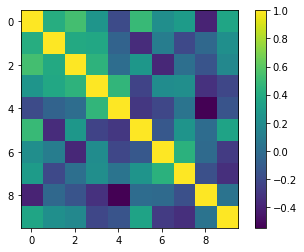

In [86]:
# Covariance

L = Variable((torch.randn(NUM_STYLE, NUM_STYLE)*0.5).tril(-1) + torch.eye(NUM_STYLE), requires_grad=True)
if CUDA:
    L = L.cuda()

def make_cov(L):
    L_star = L.tril(-1) + L.diag().pow(2.0).diag()
    C = torch.matmul(L, L.t())
    E = torch.diag(C).pow(-0.5).diag()
    return torch.matmul(E, torch.matmul(C, E))

# def wishart_prior(L, alpha=1.0, df=None):
#     """ Notes: 
    
#         * defined as a function of a lower-triangular matrix
#         * this is missing a term, but shouldn't matter so long as we do not try to optimize df
#         * here we assume that the specified parameter V is of the form V = \alpha I 
#     """
#     X = make_cov(L)
#     p = L.shape[0]
#     if df is None:
#         df = p+1
#     tr_V_inv_X = X.diag().sum() / alpha
#     log_det_V = p*np.log(alpha)
#     log_det_X = L.diag().pow(2).log().sum()
#     return 0.5*(df-p-1)*log_det_X - 0.5*tr_V_inv_X - 0.5*df*log_det_V

# print(wishart_prior(L, alpha=1.0/NUM_STYLE).unsqueeze(0))
plt.imshow(make_cov(L).data.numpy())
plt.colorbar();

In [87]:
def binary_cross_entropy(x_mean, x, EPS=1e-9):
    return - (torch.log(x_mean + EPS) * x + 
              torch.log(1 - x_mean + EPS) * (1 - x)).sum(-1)

class Decoder(nn.Module):
    
    def __init__(self, num_pixels=NUM_PIXELS,
                       num_hidden1=NUM_HIDDEN1,
                       num_hidden2=NUM_HIDDEN2,
                       num_style=NUM_STYLE):
#                        num_digits=NUM_DIGITS):
        
        super(self.__class__, self).__init__()
        self.dec_hidden = nn.Sequential(
                            nn.Linear(num_style, num_hidden2),
                            nn.ReLU(),
                            nn.Linear(num_hidden2, num_hidden1),
                            nn.ReLU())
        
        # prior for digit (y)
#         self.digit_log_weights = Parameter(torch.zeros(num_digits))
#         self.digit_temp = 0.66
        
        # prior for features (z)
        self.style_mean = Parameter(torch.zeros(num_style))
        self.style_log_std = Parameter(torch.zeros(num_style))
        
        self.dec_images = nn.Sequential(
                            nn.Linear(num_hidden1, num_pixels),
                            nn.Sigmoid())
        
        
    def forward(self, images, q=None, num_samples=None):
        p = probtorch.Trace()
        
        # sample digits : unkown or observed
#         digits = digits = p.concrete(self.digit_log_weights, self.digit_temp,
#                             value=q['y'],
#                             name='y')
        
        # sample features : unkown
        C = make_cov(L)
        styles = p.multivariate_normal(Variable(C.data.new(C.shape[0]).fill_(0.0)), 
                                       C,
                                       value=q['z'],
                                       name='z')
        
        hiddens = self.dec_hidden(styles)
        images_mean = self.dec_images(hiddens)
        p.loss(binary_cross_entropy, images_mean, images, name='images')
#         p.factor(wishart_prior(L, 1.0/NUM_STYLE).unsqueeze(0), name='covariance_prior')
        return p

# Loss

In [88]:
def elbo(q, p, alpha=ALPHA, beta=BETA):
    return probtorch.objectives.marginal.elbo(q, p, sample_dim=0, batch_dim=1,
                                              alpha=alpha, beta=beta)

# Data

In [89]:
from torchvision import datasets, transforms
import os 
DATA_PATH = '../data'

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

train_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=True, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 
test_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=False, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 

# Training and Testing

In [90]:
enc = Encoder()
dec = Decoder()
if CUDA:
    enc.cuda()
    dec.cuda()
optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters())+[L,],
                              lr=LEARNING_RATE)


In [91]:
def train(data, enc, dec, optimizer, 
          label_mask={}, label_fraction=LABEL_FRACTION):
    epoch_elbo = 0.0
    enc.train()
    dec.train()
    N = 0
    for b, (images, labels) in enumerate(data):
        
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            images = Variable(images)
            optimizer.zero_grad()
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            loss = -elbo(q, p)
            loss.backward()
            optimizer.step()
            if CUDA:
                loss = loss.cpu()
            epoch_elbo -= loss.data.numpy()[0]
    return epoch_elbo / N, {} # label_mask


def test(data, enc, dec, infer=True):
    enc.eval()
    dec.eval()
    epoch_elbo = 0.0
    epoch_correct = 0
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            images = Variable(images)
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            batch_elbo = elbo(q, p)
            if CUDA:
                batch_elbo = batch_elbo.cpu()
            epoch_elbo += batch_elbo.data.numpy()[0]
            
            log_p = p.log_joint(0, 1)
            log_q = q.log_joint(0, 1)
            log_w = log_p - log_q
            w = torch.nn.functional.softmax(log_w, 0)

    return epoch_elbo / N, 0.0 # epoch_correct / N


### Track every term in ELBO separately

In [92]:
from probtorch.objectives.montecarlo import log_like
from probtorch.distributions import Concrete
from numbers import Number
from torch.nn.functional import softmax

def elbo_track(q, p, sample_dim, batch_dim):
    y = q.conditioned()
    log_weights = q.log_joint(sample_dim, batch_dim, y)
    z_continuous = [n for n in q.sampled() if n in p and not isinstance(q[n].dist, Concrete)]
    log_avg_qz, log_avg_qzd_prod = q.log_pair(sample_dim, batch_dim, z_continuous)
    log_pz = p.log_joint(sample_dim, batch_dim, z_continuous)
    log_qz = q.log_joint(sample_dim, batch_dim, z_continuous)
    total_correlation = log_avg_qz - log_avg_qzd_prod
    prior_ratio =  log_avg_qzd_prod - log_pz
    mutual_info = log_qz - log_avg_qz
    
    log_qy = log_weights
    log_py = p.log_joint(sample_dim, batch_dim, y)
    z_concrete = [n for n in q.sampled() if n in p and isinstance(q[n].dist, Concrete)]
    log_pz = p.log_joint(sample_dim, batch_dim, z_concrete)
    log_qz = q.log_joint(sample_dim, batch_dim, z_concrete)
    log_ratio = (log_qy + log_qz - log_py - log_pz)
    
    if isinstance(log_weights, Number):
        total_correlation = total_correlation.mean(0)
        prior_ratio = prior_ratio.mean(0)
        mutual_info = mutual_info.mean(0)
        log_ratio = log_ratio.mean(0)
    else:
        weights = softmax(log_weights, 0)
        total_correlation = (weights * total_correlation).sum(0)
        prior_ratio = (weights * prior_ratio).sum(0)
        mutual_info = (weights * mutual_info).sum(0)
        log_ratio = (weights * log_ratio).sum(0)
    
    total_correlation = total_correlation.mean() 
    prior_ratio = prior_ratio.mean()
    mutual_info = mutual_info.mean()
    log_ratio = log_ratio.mean() 
    
    recun_loss = log_like(q, p, sample_dim, batch_dim, log_weights=None, size_average=True, reduce=True)
    
    return total_correlation.cpu().data.numpy(), prior_ratio.cpu().data.numpy(), \
            mutual_info.cpu().data.numpy(), recun_loss.cpu().data.numpy(), log_ratio.cpu().data.numpy()


In [93]:
import time
from random import random

est_cov_hist = [np.array(make_cov(L).data.numpy())]

train_elbo_dict = {'ELBO':[], 'Recun Loss': [], 'TC': [], 'PriorZ':[], 'PriorY':[], 'MI':[]}
test_elbo_dict = {'ELBO':[], 'Recun Loss': [], 'TC': [], 'PriorZ':[], 'PriorY':[], 'MI':[]}
test_acc_list = []
mask = {}
for e in range(NUM_EPOCHS):
    train_start = time.time()
    train_elbo, mask = train(train_data, enc, dec, 
                             optimizer, mask, LABEL_FRACTION)
    train_end = time.time()
    test_start = time.time()
    test_elbo, test_accuracy = test(test_data, enc, dec)
    test_end = time.time()
    
    test_acc_list.append(test_accuracy)
    
    est_cov_hist.append(np.array(make_cov(L).data.numpy()))
    print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e, Accuracy %0.3f (%ds)' % (
            e, train_elbo, train_end - train_start, 
            test_elbo, test_accuracy, test_end - test_start))

[Epoch 0] Train: ELBO -3.0046e+00 (43s) Test: ELBO -2.4414e+00, Accuracy 0.000 (2s)
[Epoch 1] Train: ELBO -2.3745e+00 (54s) Test: ELBO -2.2881e+00, Accuracy 0.000 (2s)
[Epoch 2] Train: ELBO -2.2607e+00 (53s) Test: ELBO -2.2058e+00, Accuracy 0.000 (2s)
[Epoch 3] Train: ELBO -2.1990e+00 (52s) Test: ELBO -2.1653e+00, Accuracy 0.000 (2s)
[Epoch 4] Train: ELBO -2.1604e+00 (58s) Test: ELBO -2.1377e+00, Accuracy 0.000 (2s)
[Epoch 5] Train: ELBO -2.1338e+00 (54s) Test: ELBO -2.1212e+00, Accuracy 0.000 (2s)
[Epoch 6] Train: ELBO -2.1130e+00 (53s) Test: ELBO -2.1007e+00, Accuracy 0.000 (2s)
[Epoch 7] Train: ELBO -2.0940e+00 (56s) Test: ELBO -2.0825e+00, Accuracy 0.000 (2s)
[Epoch 8] Train: ELBO -2.0757e+00 (54s) Test: ELBO -2.0718e+00, Accuracy 0.000 (2s)
[Epoch 9] Train: ELBO -2.0608e+00 (55s) Test: ELBO -2.0637e+00, Accuracy 0.000 (2s)


## Sanity check: confirm reconstructions are okay

Question: how are we actually supposed to do this? It's very frustrating that the decoder requires both `images` and `q` as arguments, rather than simply a value `z`.

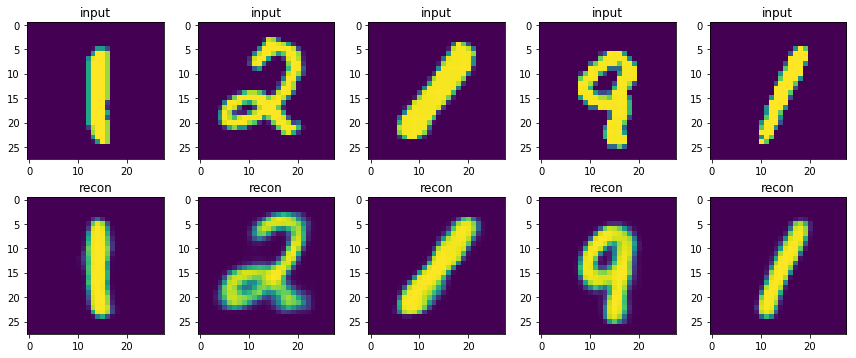

In [97]:
inputs = next(iter(test_data))[0][:5].view(-1, NUM_PIXELS)
recon = dec.dec_images(dec.dec_hidden(enc(Variable(inputs.unsqueeze(0)))['z'].value)).data.squeeze(0)
plt.figure(figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(inputs[i].view(28,28))
    plt.title("input")
    plt.subplot(2,5,i+6)
    plt.imshow(recon[i].view(28,28))
    plt.title("recon");
    
plt.tight_layout();

## Look at covariance matrix estimates?

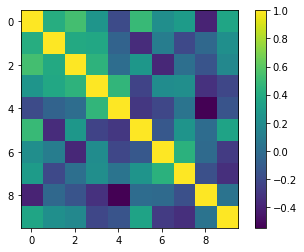

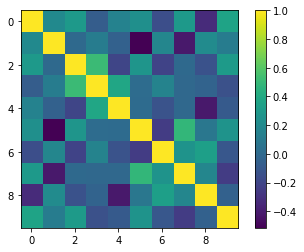

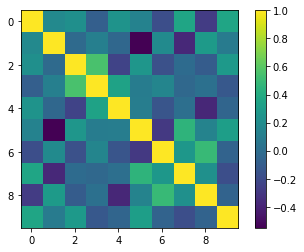

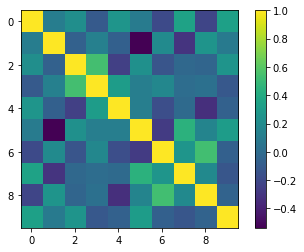

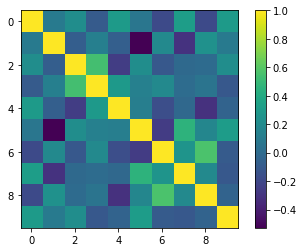

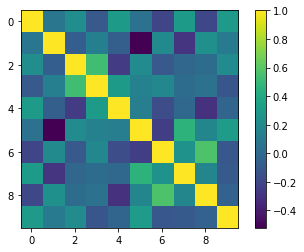

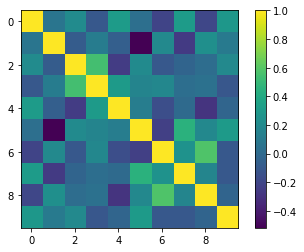

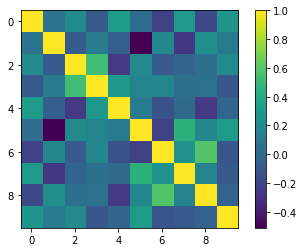

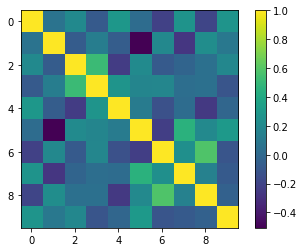

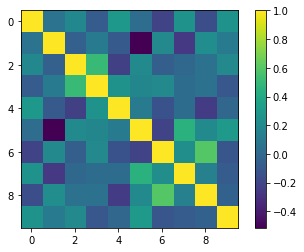

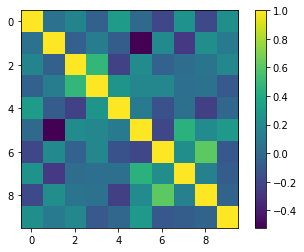

In [98]:
for C in est_cov_hist:
    plt.figure()
    plt.imshow(C.data)
    plt.colorbar();
# print(wishart_prior(L, alpha=1.0/NUM_STYLE).data[0])

# Visualize Encodings

In [99]:
# Get all the embeddings
Zs = np.zeros((len(train_data),NUM_BATCH, NUM_STYLE))
for b, (images, labels) in enumerate(train_data):
        if images.size()[0] == NUM_BATCH:
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            images = Variable(images)
            q = enc(images, num_samples=NUM_SAMPLES)
            z = q['z'].value.cpu().data.squeeze().numpy()
            Zs[b] = z
Zs = Zs.reshape(-1,NUM_STYLE)

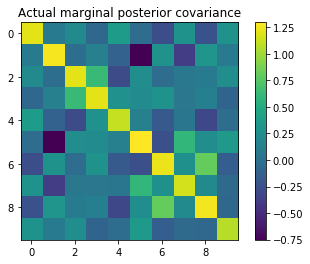

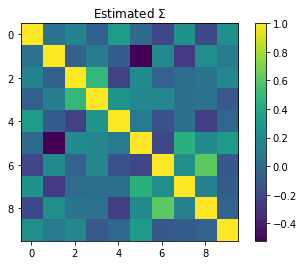

In [100]:
C = make_cov(L)
Zs_cov = np.dot((Zs - Zs.mean(0)).T, Zs - Zs.mean(0))/Zs.shape[0]
plt.title("Actual marginal posterior covariance")
plt.imshow(Zs_cov)
plt.colorbar()
plt.figure()
plt.title("Estimated $\Sigma$")
plt.imshow(C.data)
plt.colorbar()

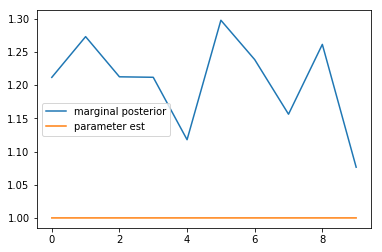

In [107]:
plt.plot(np.diag(Zs_cov))
plt.plot(C.diag().data.numpy())
plt.legend(["marginal posterior", "parameter est"])

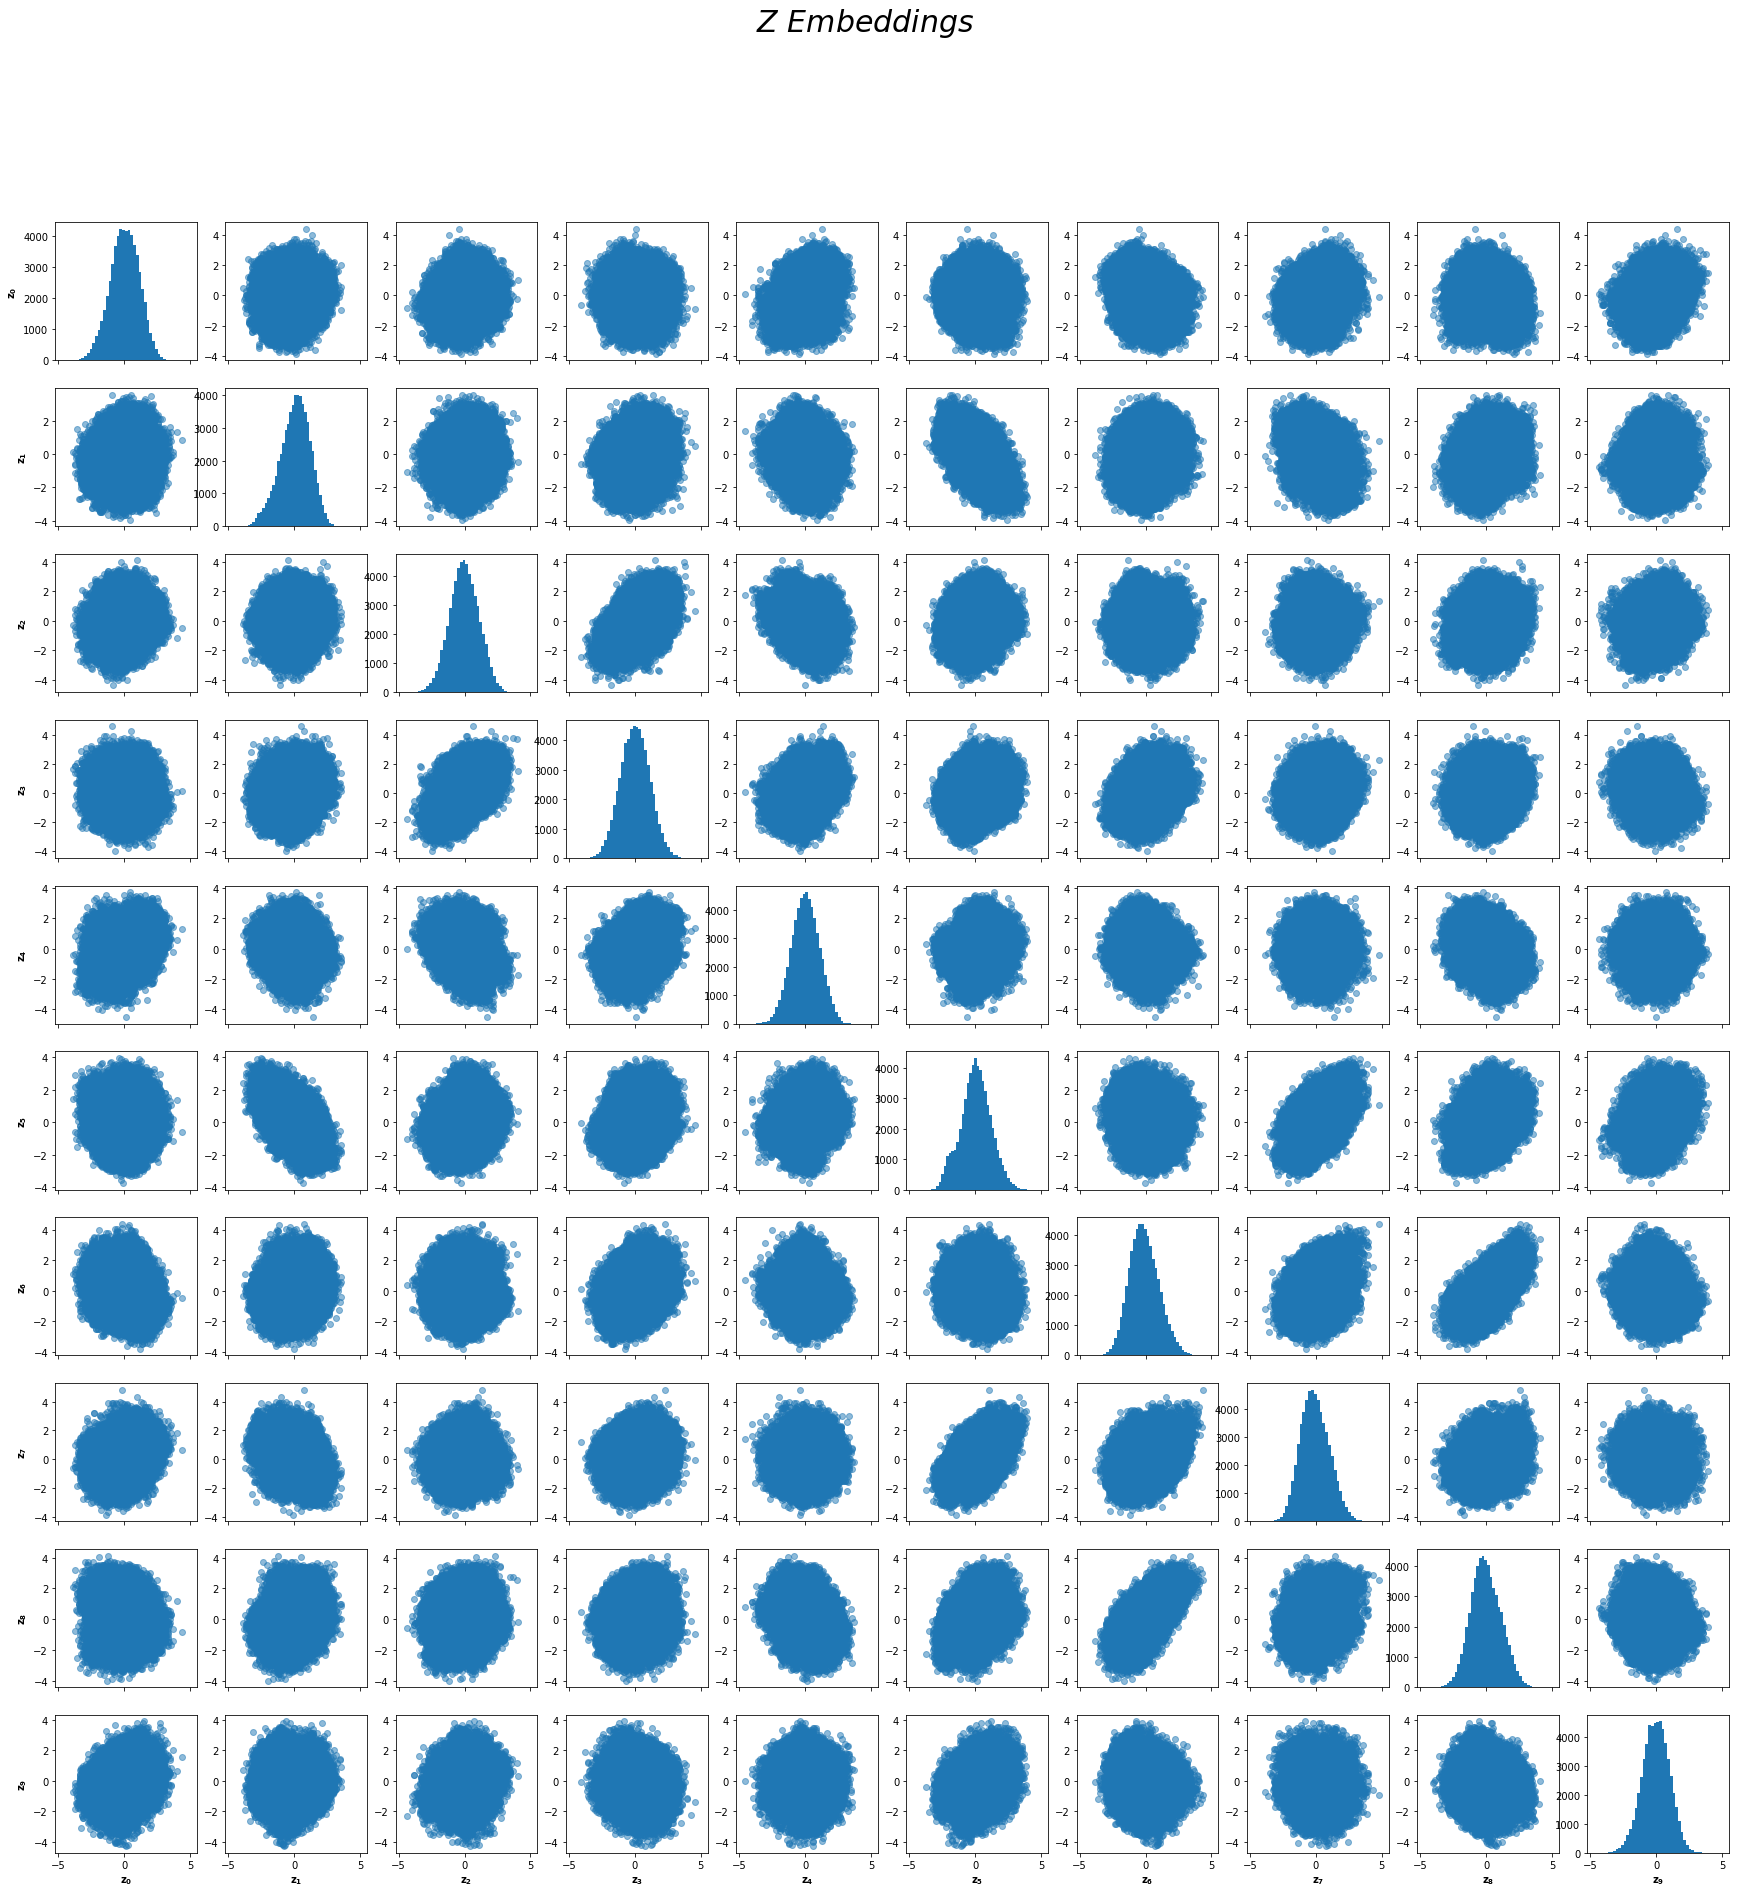

In [108]:
f, axarr = plt.subplots(NUM_STYLE, NUM_STYLE, figsize=(30, 30), sharex=True)
f.suptitle(r'$Z \ Embeddings$' , fontsize=30)

for i in range(NUM_STYLE):
    axarr[NUM_STYLE-1,i].set_xlabel(r'$\mathbf{z_{%d}}$' % i, fontsize=10)
    axarr[i,0].set_ylabel(r'$\mathbf{z_{%d}}$' % i, fontsize=10)
    for j in range(NUM_STYLE):
        if i==j:
            axarr[j,i].hist(Zs[:,i], bins=40)
        else:
            axarr[j,i].scatter(Zs[:,i],Zs[:,j],alpha=0.5)
            
plt.show()

# Let's see some Features!

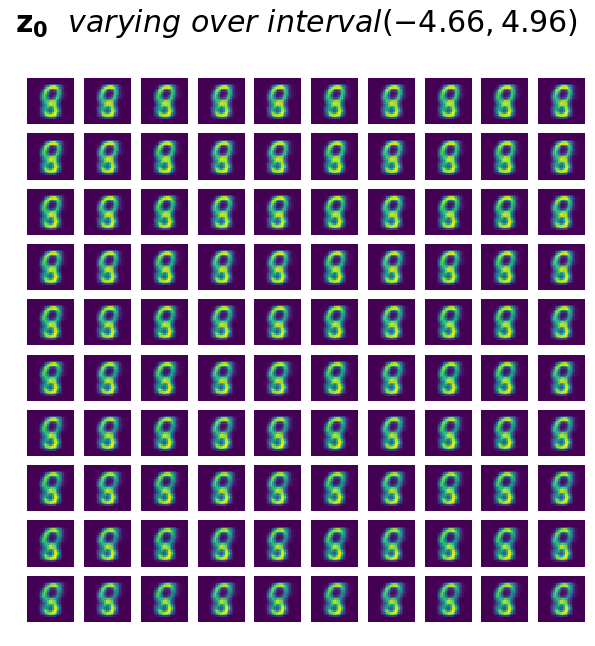

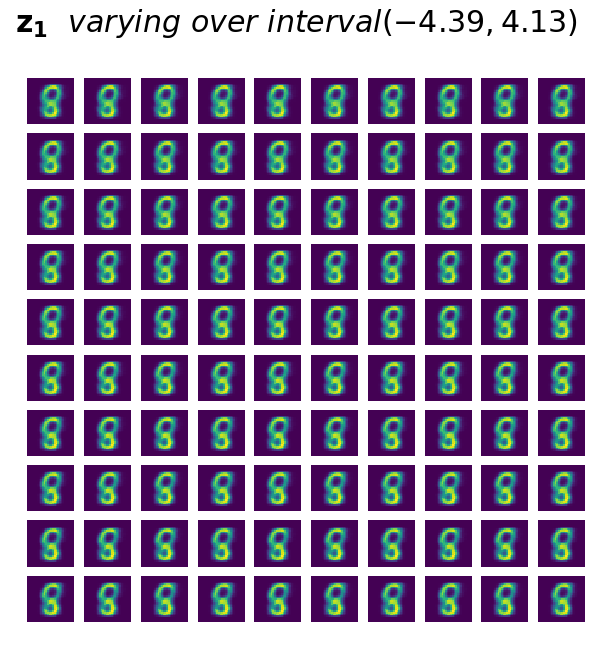

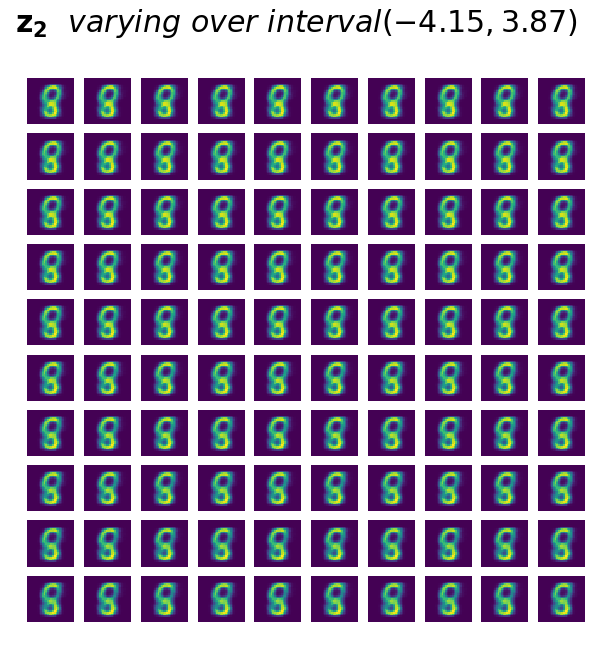

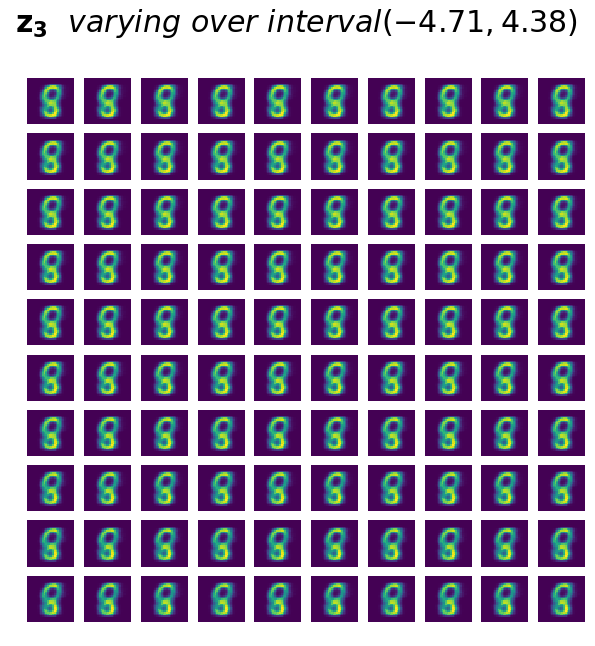

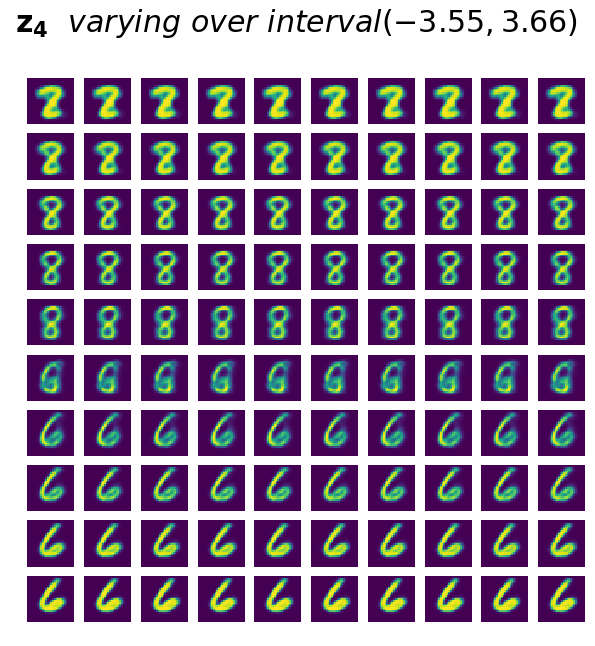

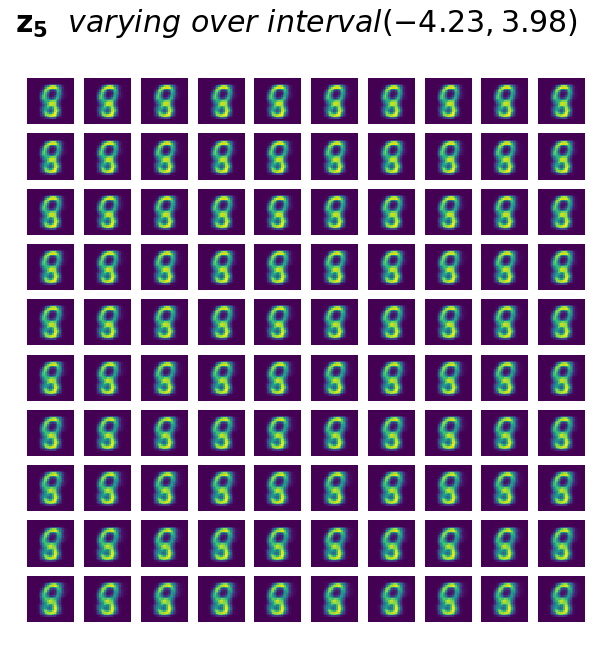

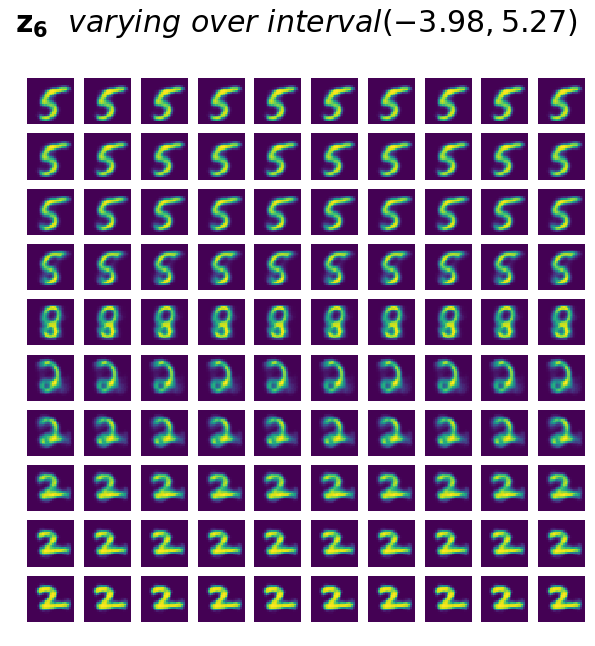

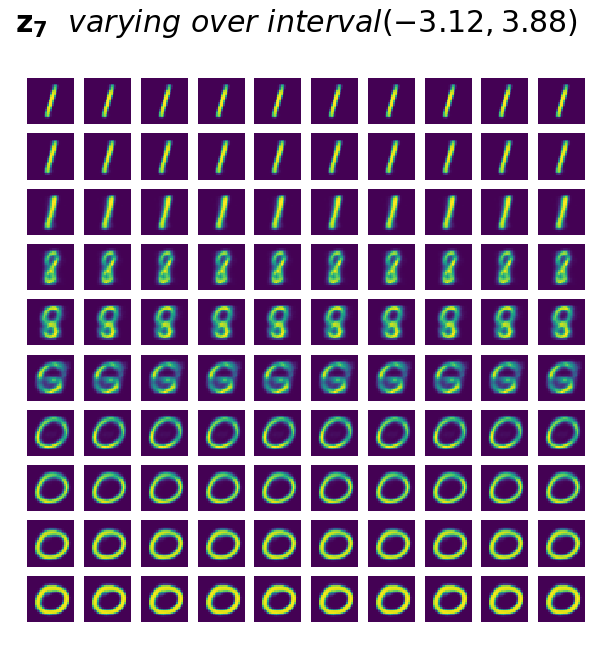

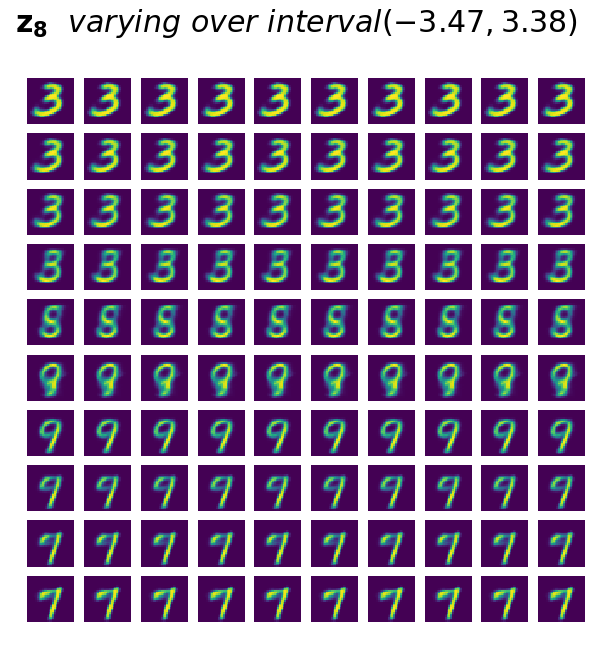

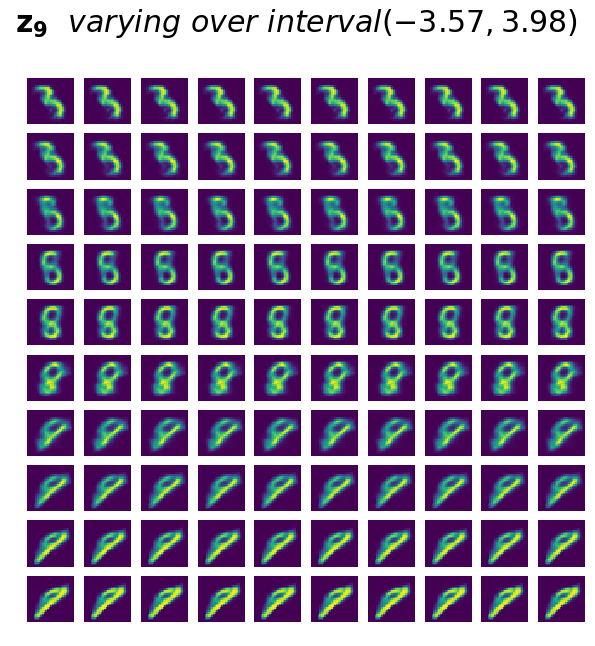

In [38]:
def vary_z2(index, zmin, zmax):
    f, axarr = plt.subplots(10,10,figsize=(10,10),sharey=True)
    f.suptitle(r'$\mathbf{z_{%d}} \ \  varying\ over\ interval (%0.2f, %0.2f)$' % (index, zmin, zmax) , fontsize=30)
    z_range = np.linspace(zmin,zmax,num=10)
    
    Z_bar = torch.FloatTensor(Zs.mean(0)).unsqueeze(0)
    
    for i in range(10):
        for j in range(10):
            z = Z_bar.clone() # torch.zeros(1,10)
            z[0,index] = z_range[i]
            z = Variable(z)
            null_image = Variable(torch.Tensor(np.zeros((1, 784))))
#             y_hot = np.zeros((1,10))
#             y_hot[0,j] = 1
#             y_hot = Variable(torch.FloatTensor(y_hot))
            if CUDA:
                z = z.cuda()
                null_image = null_image.cuda()
#                 y_hot = y_hot.cuda()
            q_null = {'z': z } # , 'y':y_hot}
            p = dec(null_image, q_null, num_samples=NUM_SAMPLES) 
            image = p['images']
            image = image.value.cpu().data.numpy().reshape(28,28)
            axarr[i,j].imshow(image)
            axarr[i,j].axis('off')
            
    return None

for style in range(NUM_STYLE):
    vary_z2(style, Zs[:,style].min(), Zs[:,style].max())
    plt.show()

Well, at least the last dimension seems to encode something?